In [1]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

from modAL.models import ActiveLearner

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
import math

%matplotlib inline

In [2]:
# cleaned version of the data after removing outliers and negative values
path='/workspace/malathi/steam_turbine_stage_1_POC/notebooks/version_1/df_sorted.csv'
data=pd.read_csv(path)
data.shape

(7077, 6)

In [3]:
INPUT_COLUMNS=[ 'expansion ratio','corrected speed','ImpulseStage_CurrentStroke']
OUTPUT_COLUMNS=['ImpulseStage_Power', 'Impulse_Discharge_Temperature', 'corrected mass flow']

In [4]:
data.sample(5)

,expansion ratio,corrected speed,ImpulseStage_CurrentStroke,ImpulseStage_Power,Impulse_Discharge_Temperature,corrected mass flow
1524,3.717742,135.091320,19.17,911.921387,373.927277,6.374565
723,5.642181,156.321695,13.45,503.988678,235.739029,4.039479
6324,1.353807,145.151337,47.79,1716.999023,381.965363,18.769650
6017,1.381020,137.854979,44.93,1675.470459,359.122345,18.609456
5446,1.621614,141.738218,36.35,1823.536255,347.623871,15.764721


In [5]:
# predictions for 'Impulsestage_Power'
X=data.drop(OUTPUT_COLUMNS,axis=1)
y=data['ImpulseStage_Power']
print(X.shape,y.shape)


(7077, 3) (7077,)


In [17]:
XX=X.values.reshape(-1,3)
yy=y.values.reshape(-1,1)
print(XX.shape,yy.shape)

(7077, 3) (7077, 1)


In [18]:
train_x,test_x,train_y,test_y = train_test_split(XX,yy,test_size=0.75,random_state=999)
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(1769, 3) (1769, 1) (5308, 3) (5308, 1)


In [19]:
def GP_regression_std(regressor, data):
    _, std = regressor.predict(data, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, data[query_idx]

In [20]:
n_initial=250
initial_idx=np.random.choice(range(len(XX)),size=n_initial,replace=False)
X_training,y_training = XX[initial_idx],yy[initial_idx]

In [34]:
#Kernel # not added noise here lower bound=1e-3  upper bound = 1e1
#ConvergenceWarning: The optimal value found for dimension 0 of parameter
#length_scale is close to the specified lower bound 0.1.
#Decreasing the bound and calling fit again may find a better value.
#
# decreasing the bound causes convergence warning
# need to scale the variables 
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2,1e1))
regressor = ActiveLearner(
            estimator=GaussianProcessRegressor(kernel=kernel),
            query_strategy=GP_regression_std,
            X_training = X_training, y_training = y_training
           )

In [35]:
y_pre,y_std = regressor.predict(test_x,return_std=True)

Text(0, 0.5, 'Predicted')

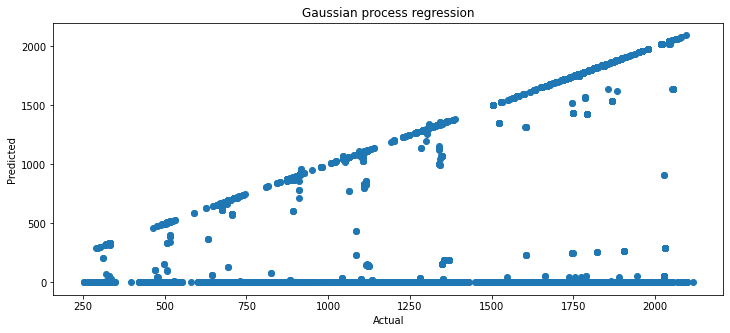

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.errorbar(test_y, y_pre, yerr=y_std, fmt='o')
plt.title('Gaussian process regression')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [36]:
#bug
y_pre[0:5]

array([[0.00000000e+000],
       [2.49086584e+002],
       [3.78912359e-276],
       [1.83000613e-235],
       [0.00000000e+000]])

In [37]:
y_std[0:5]

array([1.        , 0.99014738, 1.        , 1.        , 1.        ])

In [24]:
XXX=XX.copy()
yyy=yy.copy()

In [38]:
# Apply query strategy in Active Learning
#
n_queries = 25
for idx in range(n_queries):
    query_idx, query_instance = regressor.query(XX)
    #print(query_idx,query_instance)
    regressor.teach(XX[query_idx].reshape(1,-1),yy[query_idx].reshape(-1,1))

In [ ]:
y_pred_final,y_std_final = regressor.predict(test_x, return_std = True)

In [ ]:
y_pred_final[0:10]

In [ ]:
y_std_final[0:10]

In [ ]:
yy_pred_final,yy_std_final=y_pred_final.ravel(),y_std_final.ravel() 

Text(0, 0.5, 'Predicted')

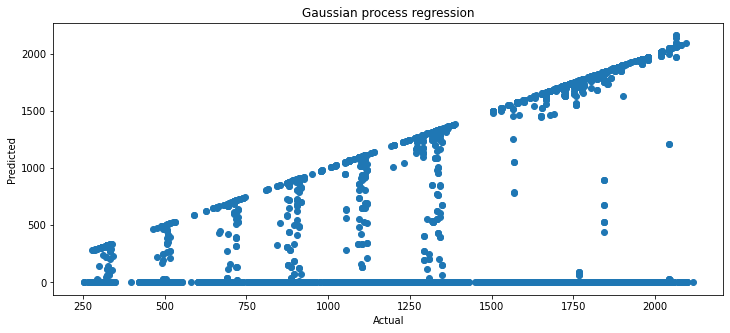

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.errorbar(test_y, yy_pred_final, yerr=yy_std_final, fmt='o')
plt.title('Gaussian process regression')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [ ]:
# Scale the variables

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#  fit  the scaler to the train set
scaler.fit(X_train[INPUT_C]) 
# transform the train and test set
X_train[INPUT_C] = scaler.transform(X_train[INPUT_C])
X_test[INPUT_C] = scaler.transform(X_test[INPUT_C])